## Show results - Test 

In [2]:
import numpy as np
import pandas as pd
#from pandas import DataFrame
import matplotlib.pyplot as plt
import matplotlib.colors as colors

%matplotlib inline
import pickle
import palettable
from scipy.sparse import csr_matrix, vstack
from scipy.optimize import curve_fit
import sys 
from netCDF4 import num2date, date2num
import xarray as xr
from netCDF4 import Dataset

sys.path.append('../../')

from climada.engine import Impact
from climada.entity import Exposures
from climada.hazard import Hazard

from src.impact_calculation.impact_heat import *
from src.util.plots import *

fig_dir = '../figures/'

## Damage cost for each scenario, year and labor type

In [10]:
pickle_in = \
open('../../output/mortality_results/impact_100mc.pickle','rb')
impacts_mortality = pickle.load(pickle_in)

agg_impacts_mc = impacts_mortality.agg_impacts_mc
median_impact_matrices = impacts_mortality.median_impact_matrices


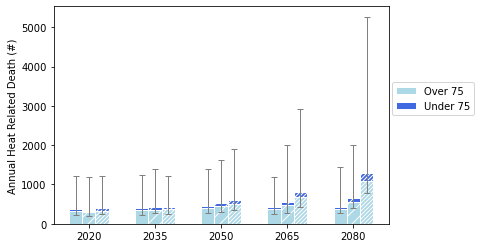

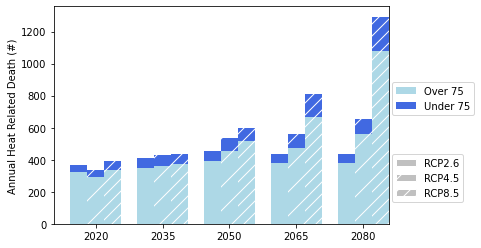

In [11]:
plot_impacts_heat(agg_impacts_mc, 'Annual Heat Related Death (#)', color=['lightblue', 'royalblue'])

#plt.savefig(''.join([fig_dir,'loss_ch/predicted_loss_2020_2065_werror.pdf']),bbox_inches='tight')


## Spatial Impact

In [7]:
category = 'O'
cm = palettable.scientific.sequential.LaJolla_20.mpl_colormap

directory_exposures = '../../input_data/exposures/'
exposures_file = ''.join([directory_exposures, 'exposures_mortality_ch_', category, '.h5'])
exposures = Exposures()
exposures.read_hdf5(exposures_file)
impact = impacts_mortality.median_matrix_as_impact(median_impact_matrices['RCP85'][2020]['U'], exposures, unit='Annual Heat Related Death (#)', percentage=False)
#impact.plot_hexbin_impact_exposure(pop_name=False, cmap=cm, buffer=0.1)

2020-10-27 17:34:01,867 - climada.entity.exposures.base - INFO - Reading ../../input_data/exposures/exposures_mortality_ch_O.h5


In [8]:
impact = impacts_mortality.median_matrix_as_impact(median_impact_matrices['RCP85'][2020]['U'], exposures, unit='Annual Heat Related Death (#)', percentage=False, canton='Basel-Stadt')
#impact.plot_hexbin_impact_exposure(pop_name=False, cmap=cm, buffer=0.1)

## Relative change map

In [8]:
impacts_rel = Impact()
impacts_rel.imp_mat = ImpactsHeatMortality.compute_relative_change(median_impact_matrices['RCP85'][2050]['U'], median_impact_matrices['RCP85'][2020]['U'])
impacts_rel.plot_hexbin_impact_exposure(pop_name=False, cmap=cm, buffer=0.1)

## Canton Impacts

In [15]:
pickle_in = \
open('../../output/mortality_results/impact_100mc.pickle','rb')
impacts_mortality = pickle.load(pickle_in)

agg_impacts_mc = impacts_mortality.agg_impacts_mc
median_impact_matrices = impacts_mortality.median_impact_matrices

directory_exposures = '../../input_data/exposures/'
exposures = {}
for code, category in {'O': 'Over 75', 'U': 'Under 75'}.items():    
    exposures_file = ''.join([directory_exposures, 'exposures_mortality_ch_', code,'.h5'])
    exposures[category] = Exposures()
    exposures[category].read_hdf5(exposures_file)
    #exposures[category] = Exposures(exposures[category])
    exposures[category].check()

agg_impact_zurich = impacts_mortality.calculate_impact_agg_canton('Zürich', exposures)

2020-10-27 20:30:54,389 - climada.entity.exposures.base - INFO - Reading ../../input_data/exposures/exposures_mortality_ch_O.h5
2020-10-27 20:30:57,141 - climada.entity.exposures.base - INFO - centr_ not set.
2020-10-27 20:30:57,142 - climada.entity.exposures.base - INFO - deductible not set.
2020-10-27 20:30:57,143 - climada.entity.exposures.base - INFO - cover not set.
2020-10-27 20:30:57,143 - climada.entity.exposures.base - INFO - category_id not set.
2020-10-27 20:30:57,144 - climada.entity.exposures.base - INFO - region_id not set.
2020-10-27 20:30:57,145 - climada.entity.exposures.base - INFO - Reading ../../input_data/exposures/exposures_mortality_ch_U.h5
2020-10-27 20:30:58,979 - climada.entity.exposures.base - INFO - centr_ not set.
2020-10-27 20:30:58,980 - climada.entity.exposures.base - INFO - deductible not set.
2020-10-27 20:30:58,981 - climada.entity.exposures.base - INFO - cover not set.
2020-10-27 20:30:58,981 - climada.entity.exposures.base - INFO - category_id not s

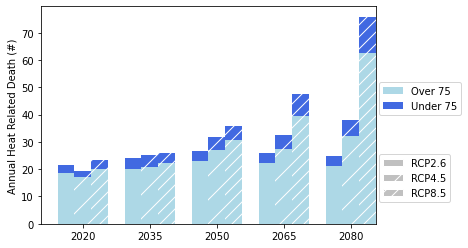

In [16]:
plot_impacts_heat(agg_impact_zurich, 'Annual Heat Related Death (#)',uncertainty=False, color=['lightblue', 'royalblue'])

In [21]:
exposures['Over 75']['canton'].unique()

array(['Vaud', 'Neuchâtel', 'Fribourg', 'Valais', 'Bern', 'Jura',
       'Solothurn', 'Basel-Landschaft', 'Basel-Stadt', 'Aargau', 'Luzern',
       'Obwalden', 'Nidwalden', 'Zürich', 'Schwyz', 'Zug', 'Schaffhausen',
       'Ticino', 'Uri', 'Thurgau', 'Graubünden', 'St. Gallen', 'Glarus',
       'Appenzell Ausserrhoden', 'Appenzell Innerrhoden'], dtype=object)